# 3. GLM for thermophysical property prediction ⚗️

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/03_GLM_thermophysical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Goals of this exercise 🌟

* We will learn how to apply (generalized) linear regression
* We will review some performance metrics for assesing regression models

## A quick reminder ✅

The process of "learning" in the context of supervised **learning** can be seen as exploring a hypothesis space $\mathcal{H}$ looking for the most appropriate hypothesis function $h$. In the context of linear regression the hypothesis space is of course the space of linear functions.

Let's imagine our input space is two-dimensional, continuous and non-negative. This could be denoted mathematically as $\textbf{x} \in \mathbb{R}_+^2$. For example, for an ideal gas, its pressure is a function of the temperature and volume. In this case, our dataset will be a collection of $N$ points with temperature and volume values as inputs and pressure as output

$$
\{(\textbf{x}^{(1)}, y^{(1)}), (\textbf{x}^{(2)}, y^{(2)}), ..., (\textbf{x}^{(N)}, y^{(N)}) \}
$$

where for each point $\textbf{x} = [x_1, x_2]^T$. Our hypothesis function would be

$$
h(\textbf{x}, \textbf{w}) = w_0 + w_1x_1 + w_2+x_2
$$

where $\textbf{w} = [w_0, w_1, w_2]^T$ is the vector of model parameters that the machine has to learn. You will soon realize that "learn" means solving an optimization problem to arrive to a set of optimal parameters. In this case, we could for example minimize the sum of squarred errors to get the optimal parameters $\textbf{w}^* $

$$
\textbf{w}^* = argmin_{\textbf{w}} ~~ \frac{1}{2} \sum_{n=1}^N \left( y^{(n)} - h(\textbf{x}^{(n)}, \textbf{w}) \right)^2
$$

This turns out to be a convex problem. This means that there exist only one optimum which is the global optimum. 

```{attention}
Did you remember the difference between local and global optima? 
```

There are many ways in which this optimization problem can be solved. For example, we can use gradient-based methods (e.g., [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)), Hessian-based methods (e.g., [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)) or, in this case, even an [analytical solution](https://math.stackexchange.com/questions/4177039/deriving-the-normal-equation-for-linear-regression) exists!

### What about non-linear problems? 🤔

We can expand this concept to cover non-linear spaces by introducing the concept of basis functions $\phi(\textbf{x})$ that map our original inputs to a different space where the problem becomes linear. Then, in this new space we perform linear regression (or classification) and effectively we are performing non-linear regression (classification) in the original space! Nice trick right?

This get rise to what we call Generalized Linear Models (GLM)!

## Linear regression 📉

Let's now play around with this concepts by looking at a specific example: regressing thermophysical data of saturated and superheated vapor.

The data is taken from the Appendix F of {cite}`smith2004introduction`.

Let's import some libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

and then import the data

In [2]:
if 'google.colab' in str(get_ipython()):
  df = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/superheated_vapor.csv")
else:
  df = pd.read_csv("references/superheated_vapor.csv")

df.head()

,Pressure,Property,Liq_Sat,Vap_Sat,75,100,125,150,175,200,...,425,450,475,500,525,550,575,600,625,650
0,1.0,V,1.000,129200.0000,160640.0000,172180.0000,183720.0000,195270.0000,206810.0000,218350.0000,...,NaN,333730.00,NaN,356810.0000,NaN,379880.0000,NaN,402960.0000,NaN,426040.0000
1,1.0,U,29.334,2385.2000,2480.8000,2516.4000,2552.3000,2588.5000,2624.9000,2661.7000,...,NaN,3049.90,NaN,3132.4000,NaN,3216.7000,NaN,3302.6000,NaN,3390.3000
2,1.0,H,29.335,2514.4000,2641.5000,2688.6000,2736.0000,2783.7000,2831.7000,2880.1000,...,NaN,3383.60,NaN,3489.2000,NaN,3596.5000,NaN,3705.6000,NaN,3816.4000
3,1.0,S,0.106,8.9767,9.3828,9.5136,9.6365,9.7527,9.8629,9.9679,...,NaN,10.82,NaN,10.9612,NaN,11.0957,NaN,11.2243,NaN,11.3476
4,10.0,V,1.010,14670.0000,16030.0000,17190.0000,18350.0000,19510.0000,20660.0000,21820.0000,...,NaN,33370.00,NaN,35670.0000,NaN,37980.0000,NaN,40290.0000,NaN,42600.0000


Many things to notice from observing the data above:

* We have 4 different properties V, U, H and S referring to the specific properties volume [cm$^3$ g$^{-1}$], internal energy [kJ kg$^{-1}$], enthalpy [kJ kg$^{-1}$] and entropy[kJ kg$^{-1}$ K$^{-1}$], respectively.
* We have values for each property at different pressures [kPa] and temperatures [°C].
* We have also the value of each property at each pressure for the saturated liquid and vapor.

Since we plan to build models per each property individually, let's separate the data per property.

In [3]:
V = df.loc[df['Property'] == 'V']
U = df.loc[df['Property'] == 'U']
H = df.loc[df['Property'] == 'H']
S = df.loc[df['Property'] == 'S']

Ploting the data, whenever possible, is always useful! So, let's plot for instance the saturated liquid data to see what trends it follows

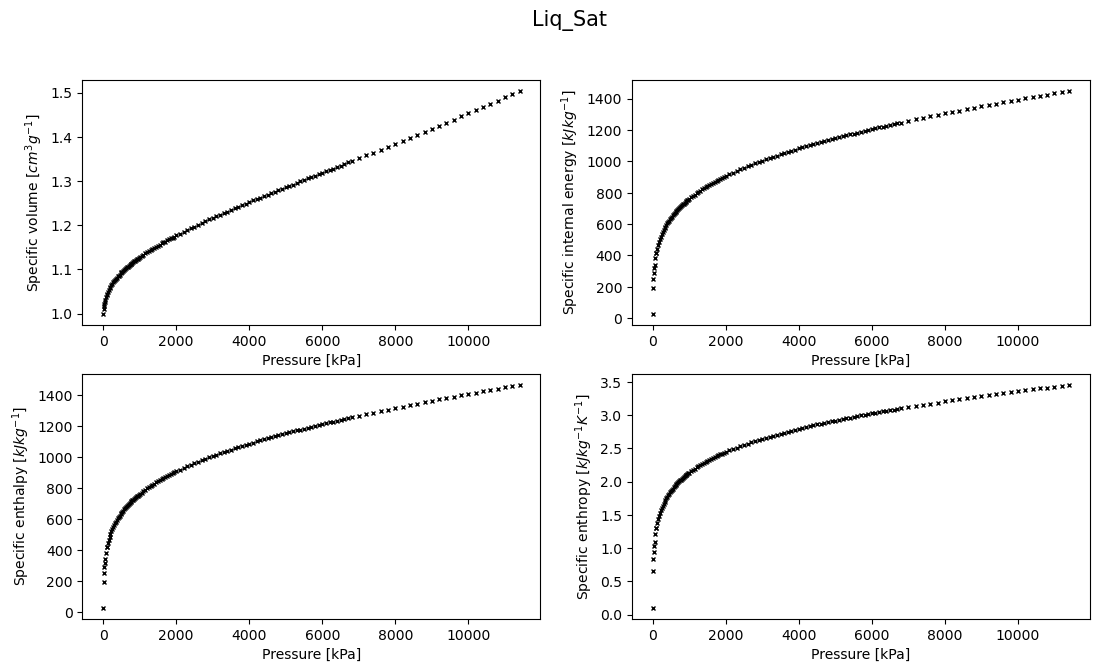

In [4]:
property_to_plot = 'Liq_Sat'

# Plot saturated liquid
plt.figure(figsize=(13, 7))
plt.subplot(221)
plt.plot(V['Pressure'], V[property_to_plot], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')

plt.subplot(222)
plt.plot(U['Pressure'], U[property_to_plot], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific internal energy [$kJ kg^{-1}$]')

plt.subplot(223)
plt.plot(H['Pressure'], H[property_to_plot], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific enthalpy [$kJ kg^{-1}$]')

plt.subplot(224)
plt.plot(S['Pressure'], S[property_to_plot], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific enthropy [$kJ kg^{-1} K^{-1}$]')

plt.suptitle(property_to_plot, size=15)
plt.show()

We can also get some statical description of the data really fast by calling the method [`describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) on a DataFrame or Series

In [5]:
V['Liq_Sat'].describe()

count    136.000000
mean       1.215382
std        0.128941
min        1.000000
25%        1.111500
50%        1.191000
75%        1.309750
max        1.504000
Name: Liq_Sat, dtype: float64

Well, the trend is clearly non-linear in the whole range of pressures right?

We will focus in this exercise on a single property, let's take for instance the specific volume of the saturated liquid.

Our goal is to build a mathematical model (for now using (generalized) linear regression), that predicts the specific volume of a saturated liquid as a function of the pressure. This means that we are dealing with a one-dimensional problem.

It is also quite noticible to see that a simple line is not going to fit the data very well on the whole range of pressures. Do you see why looking at your data first is important? This process is formally known as [Exploratory Data Analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis) and refers to the general task of analyzing the data using statistical metrics, visualization tools, etc...

```{important}
Before starting modeling, explore your data!
```

For now, let's assume we only know how to do a simple linear regression. Maybe one idea would be to split the data into sections and approximate each section with a different linear regression. This of course will result in a discrete model that is not very handdy... But let's try

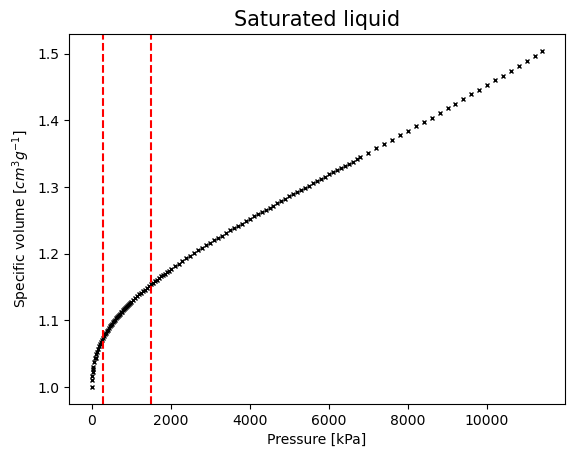

In [6]:
lim_1 = 300
lim_2 = 1500

plt.figure()
plt.plot(V['Pressure'], V['Liq_Sat'], 'kx', markersize=3)
plt.axvline(lim_1, linestyle='--', color='r')
plt.axvline(lim_2, linestyle='--', color='r')
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')
plt.title('Saturated liquid', size=15)
plt.show()

 Let's extract these sections from our data

In [7]:
First_P  = V['Pressure'].loc[V['Pressure'] < lim_1].to_numpy().reshape(-1, 1)
First_V  = V['Liq_Sat'].loc[V['Pressure'] < lim_1].to_numpy().reshape(-1, 1)

Second_P = V['Pressure'].loc[(V['Pressure'] >= lim_1) & 
                                  (V['Pressure'] < lim_2)].to_numpy().reshape(-1, 1)
Second_V = V['Liq_Sat'].loc[(V['Pressure'] >= lim_1) & 
                                  (V['Pressure'] < lim_2)].to_numpy().reshape(-1, 1)

Third_P  = V['Pressure'].loc[V['Pressure'] >= lim_2].to_numpy().reshape(-1, 1)
Third_V  = V['Liq_Sat'].loc[V['Pressure'] >= lim_2].to_numpy().reshape(-1, 1)

Now, we fit the 3 models

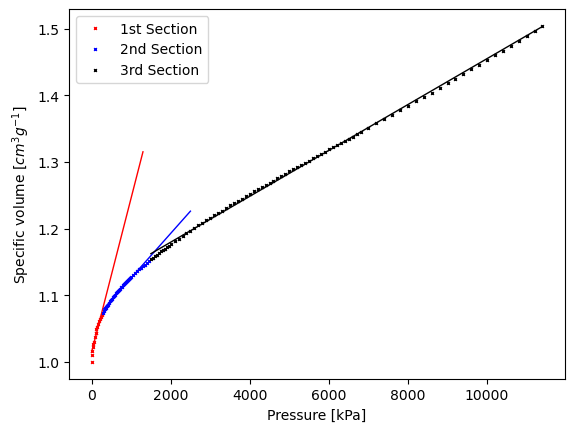

In [8]:
LR_1 = LinearRegression().fit(First_P, First_V)
LR_2 = LinearRegression().fit(Second_P, Second_V)
LR_3 = LinearRegression().fit(Third_P, Third_V)

# - Plot splits and models
plt.figure()
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')

# -- First split
plt.plot(First_P, First_V, 'rx', markersize=2, label='1st Section')    
plt.plot(np.linspace(0, lim_1 + 1000, 100), 
         LR_1.predict(np.linspace(0,lim_1 + 1000, 100).reshape(-1, 1)),'r', linewidth=1) 

# -- Second split
plt.plot(Second_P, Second_V, 'bx', markersize=2, label='2nd Section')  
plt.plot(np.linspace(lim_1, lim_2+1000, 100), 
         LR_2.predict(np.linspace(lim_1, lim_2+1000, 100).reshape(-1, 1)),'b', linewidth=1)


# -- Third split
plt.plot(Third_P, Third_V, 'kx', markersize=2, label='3rd Section')    
plt.plot(np.linspace(lim_2, max(Third_P), 100), 
         LR_3.predict(np.linspace(lim_2, max(Third_P), 100).reshape(-1, 1)),'k', linewidth=1)

plt.legend()
plt.show()

We can check how well our model is fitting our data by printing the R$^2$ coefficient

The coefficient R$^2$ is defined as $1 - \frac{u}{v}$, where $u$ is the residual sum of squares $\sum (y - \hat{y})^2$ and $v$ is the total sum of squares $\sum (y - \mu_y)^2$. Here, $y$ denotes the true output value, $\hat{y}$ denotes the predicted output and $\mu_y$ stands for the mean of the output data. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the mean of $y$, disregarding the input features, would get a R$^2$ score of 0.0.

In [9]:
print('\n R2 for 1st split:', LR_1.score(First_P, First_V))
print('\n R2 for 2nd split:', LR_2.score(Second_P, Second_V))
print('\n R2 for 3rd split:', LR_3.score(Third_P, Third_V))


 R2 for 1st split: 0.9263208134364597

 R2 for 2nd split: 0.9870087187227413

 R2 for 3rd split: 0.9990370407798591


```{admonition} Question
:class: hint
What about training and test split? 😟 Can my model extrapolate to other pressures accurately? 
```

To check the model parameters $\textbf{w}$

In [10]:
print('\n Slope for 1st split    :', LR_1.coef_)
print(' Intercept for 1st split:', LR_1.intercept_)

print('\n Slope for 2nd split    :', LR_2.coef_)
print(' Intercept for 2nd split:', LR_2.intercept_)

print('\n Slope for 3rd split    :', LR_3.coef_)
print(' Intercept for 3rd split:', LR_3.intercept_)


 Slope for 1st split    : [[0.00023137]]
 Intercept for 1st split: [1.01438786]

 Slope for 2nd split    : [[6.67710359e-05]]
 Intercept for 2nd split: [1.05921557]

 Slope for 3rd split    : [[3.44236231e-05]]
 Intercept for 3rd split: [1.11072464]


```{admonition} Question
:class: hint
What about scaling? 😟 Does scaling matters for linear regression? Why or why not?
```

## Multivariate-linear regression 🤹

In our data set, we have a bunch of data corresponding to superheated vapor. We can take a look into it to see how can we create a mathematical model for it. This would be useful later for process simulation or process optimization. 

Let's pick just one property for now, the enthalpy.

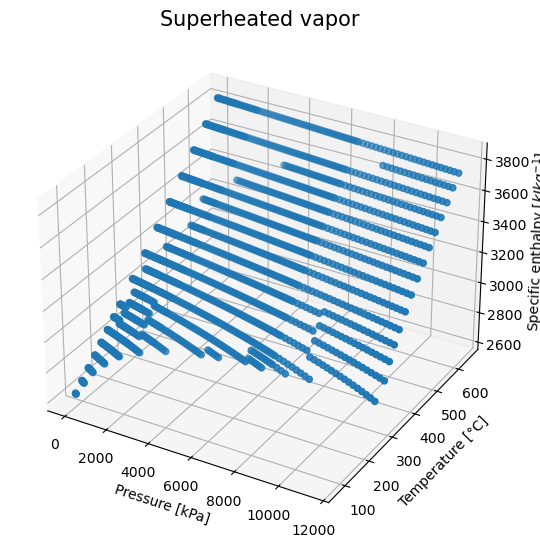

In [11]:
#%matplotlib qt #Uncomment this line to plot in a separate window (not available in Colab)

fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

x = H['Pressure']
y = np.array([int(H.columns[4:][i]) for i in range(len(H.columns[4:]))])
X,Y = np.meshgrid(x,y)
Z = H.loc[:, '75':'650']

ax.scatter(X, Y, Z.T)
ax.set_xlabel('Pressure [kPa]')
ax.set_ylabel('Temperature [°C]')
ax.set_zlabel('Specific enthalpy [$kJ kg^{-1}$]')
ax.set_title('Superheated vapor', size=15)
plt.show()

It seems like a multivariate linear regression would fit our experimental data quite well, right?

You will notice that the enthalpy data contains NaN values (i.e., empty values), which we should remove before fitting our model

In [12]:
Ps   = X.reshape(-1,1)
Ts   = Y.reshape(-1,1)
Hs   = np.array(Z.T).reshape(-1,1)

# -- Clean data to eliminate NaN which cannot be used to fit the LR
H_bool  = np.isnan(Hs)
P_clean = np.zeros(len(Ps)-np.count_nonzero(H_bool))
T_clean = np.zeros(len(P_clean))
H_clean = np.zeros(len(P_clean))

j = 0
for i in range(Ps.shape[0]):
    if H_bool[i] == False:
        P_clean[j] = Ps[i]
        T_clean[j] = Ts[i]
        H_clean[j] = Hs[i]
        j += 1

/tmp/ipykernel_3103839/368142968.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P_clean[j] = Ps[i]
/tmp/ipykernel_3103839/368142968.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_clean[j] = Ts[i]
/tmp/ipykernel_3103839/368142968.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H_clean[j] = Hs[i]


### Exercise - multi-variate linear regression ❗❗

* Fit a multi-variate linear regression to the enthalpy data
* What are the model parameters?
* What is the R$^2$?
* Plot your model using [`plot_surface`](https://matplotlib.org/stable/gallery/mplot3d/surface3d.html) along with the experimental data

 Parametrs  :
Slopes: [[-0.01809618  2.26744898]]
Intercept: [2380.26531316]
R^2: 0.9876784909472981


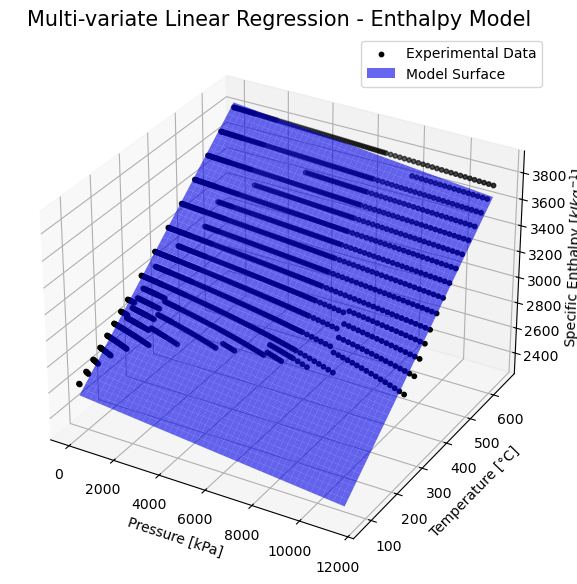

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D


P_clean = P_clean.reshape(-1, 1)
T_clean = T_clean.reshape(-1, 1)
H_clean = H_clean.reshape(-1, 1)


X = np.hstack((P_clean, T_clean))  
y = H_clean  


model = LinearRegression()
model.fit(X, y)


slope = model.coef_
intercept = model.intercept_

print(" Parametrs  :")
print("Slopes:", slope)
print("Intercept:", intercept)


y_pred = model.predict(X)


r2 = r2_score(y, y_pred)
print("R^2:", r2)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(P_clean, T_clean, H_clean, color='black', s=10, label='Experimental Data')


P_range = np.linspace(min(P_clean), max(P_clean), 50)
T_range = np.linspace(min(T_clean), max(T_clean), 50)
P_mesh, T_mesh = np.meshgrid(P_range, T_range)
H_mesh = model.predict(np.hstack((P_mesh.reshape(-1, 1), T_mesh.reshape(-1, 1)))).reshape(P_mesh.shape)


ax.plot_surface(P_mesh, T_mesh, H_mesh, color='blue', alpha=0.6, rstride=1, cstride=1, label='Model Surface')


ax.set_xlabel('Pressure [kPa]')
ax.set_ylabel('Temperature [°C]')
ax.set_zlabel('Specific Enthalpy [$kJ kg^{-1}$]')
ax.set_title('Multi-variate Linear Regression - Enthalpy Model', size=15)
ax.legend()
plt.show()


## Generalized Linear Regression 📈

Previously we sectioned the volume data for a saturated liquid into three parts and we approximate each part with a
linear regression. In this way, we obtained a discrete model for the whole range of pressures. This
type of discrete models can be sometimes troublesome when applied to optimization problems (e.g.
they have points where the gradient does not exist). A non-linear smooth model would be preferable (e.g., some sort of polynomial).

In [14]:
Ps = V['Pressure'].to_numpy().reshape(-1,1)
Vs = V['Liq_Sat'].to_numpy().reshape(-1,1)

Let's create some polynomial basis functions. For instance:

* $\phi_1(x) = x$
* $\phi_2(x) = x^2$
* $\phi_3(x) = x^3$
* $\phi_4(x) = x^4$

Notice, that by using these basis functions we will be moving the problem from one-dimension to four-dimensions, in which the new input features are given by the corresponding basis function. We will integrate this series of transformations into a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) just to exemplify its use.

In [15]:
pf = PolynomialFeatures(degree=4, include_bias=False)
LR = LinearRegression()

# Define pipeline
GLM = Pipeline([("pf", pf),  ("LR", LR) ])
GLM.fit(Ps, Vs)

Pipeline(steps=[('pf', PolynomialFeatures(degree=4, include_bias=False)),
                ('LR', LinearRegression())])

A pipeline helps us in sequentially applying a list of transformations to the data. This could help us in preventing that we forget to apply one of the transformations when using our model.

Let's plot now the GLM

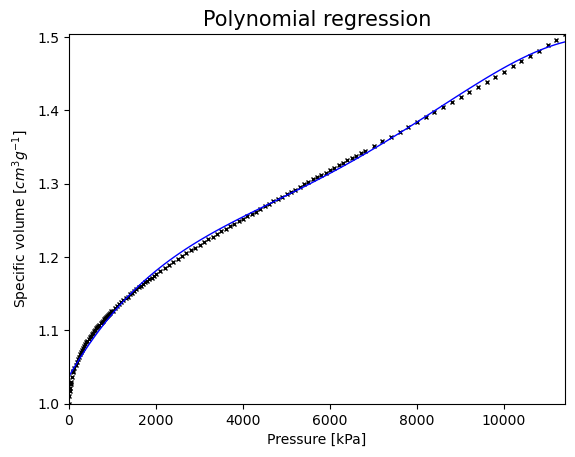

In [16]:
evaluation_points = np.linspace(Ps[0], Ps[-1], 100)

plt.figure()
plt.plot(Ps, Vs, 'kx', markersize=3)
plt.plot(evaluation_points, GLM.predict(evaluation_points), 'b', linewidth=1)
plt.title('Polynomial regression', size=15)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')
plt.xlim((0, Ps[-1]))
plt.ylim((Vs[0], Vs[-1]))
plt.show()

In [17]:
# Print model parameters
print('Parameters: ', GLM['LR'].coef_)
print('Intercept : ', GLM['LR'].intercept_)

Parameters:  [[ 1.02749631e-04 -1.93838200e-08  2.14712770e-12 -8.15517442e-17]]
Intercept :  [1.03748932]


In [18]:
print('\n R2 for GLM:', GLM.score(Ps, Vs))


 R2 for GLM: 0.9970238146790567


### Exercise - polynomial regression ❗❗

* Create a function that takes as inputs 1) the pressure data and 2) the model parameters and returns the specific volume.
* Use the polynomial model parameters obtained with sklearn as 2)
* Plot the predictions along with the experimental data. Do you obtain the same plot?

In [19]:
def poly_regression(Ps, model_params):
    w_0 = model_params[0]
    w_1 = model_params[1]
    w_2 = model_params[2]
    w_3 = model_params[3]
    w_4 = model_params[4]
    
    # Your code here
    Vs = w_0 + w_1 * Ps + w_2 * Ps**2 + w_3 * Ps**3 + w_4 * Ps**4
    return Vs

# Your code for using the function here
intercept = GLM.named_steps["LR"].intercept_.flatten()  
coefficients = GLM.named_steps["LR"].coef_.flatten()    
model_params = np.concatenate((intercept, coefficients))

Vs_pred = poly_regression(Ps.flatten(), model_params)

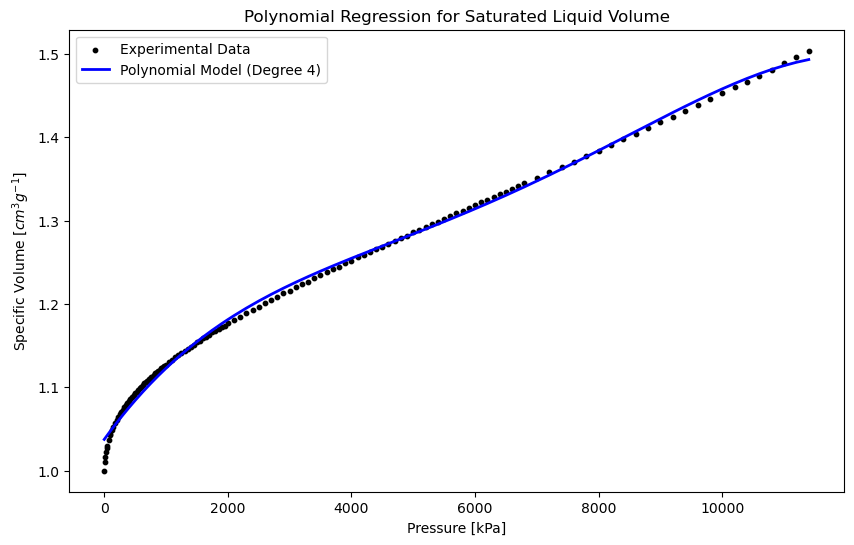

In [20]:
# Your code for plotting here
plt.figure(figsize=(10, 6))
plt.scatter(Ps, Vs, color='black', s=10, label='Experimental Data') 
plt.plot(Ps, Vs_pred, color='blue', linewidth=2, label='Polynomial Model (Degree 4)')
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific Volume [$cm^3 g^{-1}$]')
plt.title('Polynomial Regression for Saturated Liquid Volume')
plt.legend()
plt.show()

### Using a different base

Generalized Linear Models are not restriceted to polynomial features. We can, in principle, use any basis functions that we want. How can we use for example a logarithmic basis function?

In [21]:
class log_feature(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
       X_log = np.log(X)
       X_new = np.hstack((X, X_log))
       return X_new

In [22]:
log_f = log_feature()

GLM_log = Pipeline([("log_f", log_f), ("LR", LR),])
GLM_log.fit(Ps, Vs)

Pipeline(steps=[('log_f', log_feature()), ('LR', LinearRegression())])

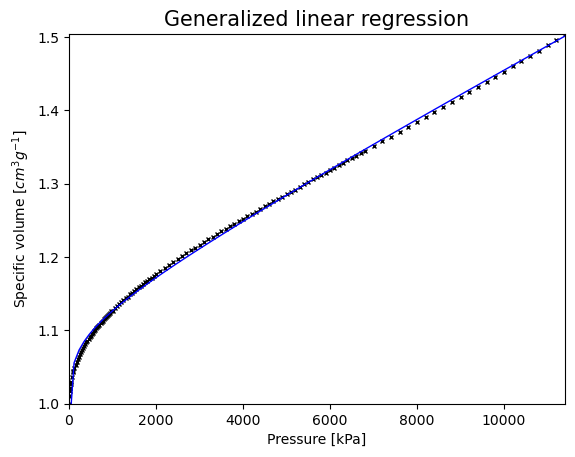

In [23]:
evaluation_points = np.linspace(Ps[0], Ps[-1], 100)

plt.figure()
plt.plot(Ps, Vs, 'kx', markersize=3)
plt.plot(evaluation_points, GLM_log.predict(evaluation_points), 'b', linewidth=1)
plt.title('Generalized linear regression', size=15)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')
plt.xlim((0, Ps[-1]))
plt.ylim((Vs[0], Vs[-1]))
plt.show()

In [24]:
# Print model parameters
print('Parameters: ', GLM_log['LR'].coef_)
print('Intercept : ', GLM_log['LR'].intercept_)

Parameters:  [[3.13403431e-05 2.00436068e-02]]
Intercept :  [0.95683431]


In [25]:
print('\n R2 for GLM:', GLM_log.score(Ps, Vs))


 R2 for GLM: 0.998201429670517


Regarding physical interpretability, what are the advantages that you see when using the logarithmic basis function vs. the polynomials?

```{hint} 
Can the pressure become negative?
```

### Exercise - Generalized linear regression ❗❗

* Create a function that takes as inputs 1) the pressure data and 2) the model parameters and returns the specific volume.
* Use the logaritmic model parameters obtained with sklearn as 2)
* Plot the predictions along with the experimental data. Do you obtain the same plot?

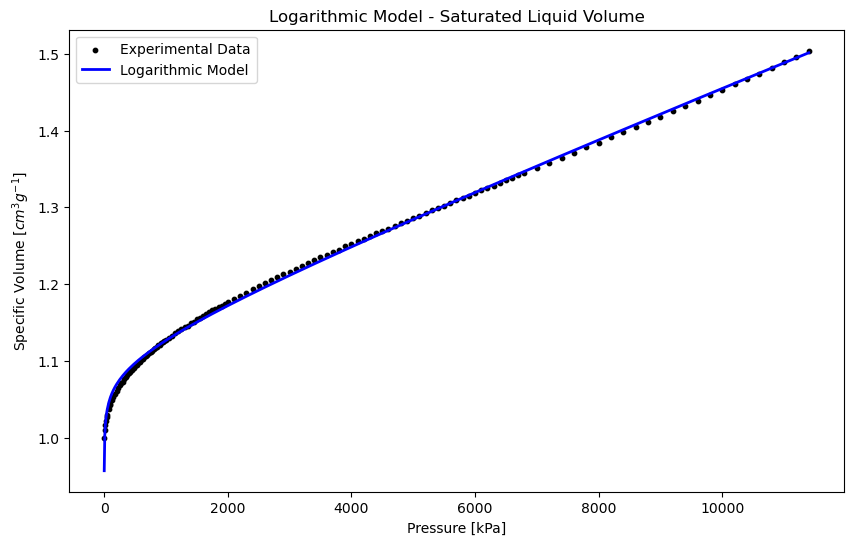

In [27]:
# Your code here

import numpy as np
import matplotlib.pyplot as plt

def log_regression(Ps, model_params):

    intercept, w_1, w_log = model_params  
    Vs = intercept + w_1 * Ps + w_log * np.log(Ps)  
    return Vs

intercept = GLM_log.named_steps["LR"].intercept_[0]
coefficients = GLM_log.named_steps["LR"].coef_[0]
model_params = [intercept] + coefficients.tolist() 

Vs_pred = log_regression(Ps.flatten(), model_params)

plt.figure(figsize=(10, 6))
plt.scatter(Ps, Vs, color='black', s=10, label='Experimental Data')  
plt.plot(Ps, Vs_pred, color='blue', linewidth=2, label='Logarithmic Model')  
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific Volume [$cm^3 g^{-1}$]')
plt.title('Logarithmic Model - Saturated Liquid Volume')
plt.legend()
plt.show()


## References

```{bibliography}
:filter: docname in docnames
```